In [1]:
import torchaudio
import torch
import torch.nn.functional as F
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import sys
sys.path.append('..')

from models.lit_cs_detector import LitCSDetector

/home/geoff/anaconda3/envs/penguin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model tinker

In [2]:
model = LitCSDetector('base')

In [3]:
path = '/media/geoff/datasets/soapies_balanced_corpora/cs_engzul_balanced/lang_targs_mult/cs_engzul_trn.pkl'
df = pd.read_pickle(path)
df.head()

,audio_fpath,tgts
0,/media/geoff/datasets/soapies_balanced_corpora...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,/media/geoff/datasets/soapies_balanced_corpora...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,/media/geoff/datasets/soapies_balanced_corpora...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,/media/geoff/datasets/soapies_balanced_corpora...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,/media/geoff/datasets/soapies_balanced_corpora...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [4]:
audio_path = df.iloc[8000]['audio_fpath']
tgts1 = torch.tensor(df.iloc[8000]['tgts'])
waveform1, sample_rate = torchaudio.load(audio_path)

audio_path = df.iloc[8001]['audio_fpath']
tgts2 = torch.tensor(df.iloc[8001]['tgts'])
waveform2, sample_rate = torchaudio.load(audio_path)

waveforms = pad_sequence([waveform1.reshape(-1, 1), waveform2.reshape(-1, 1)], batch_first=True)
ll = torch.tensor([waveform1.size(1), waveform2.size(1)])
targets = pad_sequence([tgts1.reshape(-1, 1), tgts2.reshape(-1, 1,)], padding_value=0, batch_first=True).squeeze()

In [7]:
x, lengths = model.backbone.feature_extractor(waveforms.squeeze(), ll)
x = model.backbone.encoder(x, lengths)
x.shape

torch.Size([2, 97, 768])

In [5]:
y_hat, lengths = model.forward(waveforms.squeeze(), ll)

### Cross Entropy

In [11]:
def interp_targets(targets, max_length):
    targets_ = targets.reshape(targets.size(0), 1, 1, targets.size(1)).to(torch.float32)
    interp_legnths = (1, max_length)
    ds_targets = F.interpolate(targets_, interp_legnths).squeeze()
    return ds_targets.to(torch.long)

In [12]:
targets = interp_targets(targets, torch.max(lengths))
F.cross_entropy(y_hat.view(-1, 3), targets.view(-1))

tensor(1.0835, grad_fn=<NllLossBackward0>)

### CTC

In [54]:
ds_factor = 335

In [58]:
# Hacky way to use torch's vision interpolation stuff

alpha = 0.49 # Shrink factor to get ctc to work

tgts = torch.tensor(tgts1, dtype=torch.float32).reshape(1, 1, 1, -1)
ds_size1 = int(tgts.size(-1)/ds_factor*alpha)
interp_legnths1 = (1,  ds_size1)
interp_tgts1 = F.interpolate(tgts, interp_legnths1).squeeze()

tgts = torch.tensor(tgts2, dtype=torch.float32).reshape(1, 1, 1, -1)
ds_size2 = int(tgts.size(-1)/ds_factor*alpha)
interp_legnths2 = (1,  ds_size2)
interp_tgts2 = F.interpolate(tgts, interp_legnths2).squeeze()

target = pad_sequence([interp_tgts1.reshape(-1, 1), interp_tgts2.reshape(-1, 1)], batch_first=True, padding_value=1).squeeze()
target_lengths = torch.stack([torch.tensor(ds_size1), torch.tensor(ds_size2)])

In [65]:
target = target.to(torch.long)
input = F.log_softmax(y_hat, dim=-1)
N, T, C = input.shape
input = input.view(((T, N, C)))

In [60]:
#loss = ctc_loss(input, target, input_lengths, target_lengths)
ctc_loss = torch.nn.CTCLoss(blank=0, zero_infinity=True)
ctc_loss(input, target, lengths, target_lengths)

tensor(1.7792, grad_fn=<MeanBackward0>)

In [10]:
T = 48
C = 3
N = 2

S = 30
S_min = 29

input = torch.randn(T, N, C).log_softmax(2).detach().requires_grad_()
target = torch.randint(low=1, high=C, size=(N, S), dtype=torch.long)
input_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)
target_lengths = torch.randint(low=S_min, high=S, size=(N,), dtype=torch.long)

ctc_loss = torch.nn.CTCLoss(blank=0, zero_infinity=False)

print(loss)

### Train

In [1]:
import sys
sys.path.append('..')
import torch
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, DeviceStatsMonitor
from finetuning_scheduler import FinetuningScheduler
from utils.datasets import CSDataset, collator
from torch.utils.data import DataLoader
from models.lit_cs_detector import LitCSDetector, ModelConfig

root_path = '/home/gfrost/datasets'

path = f'{root_path}/soapies_balanced_corpora/cs_engzul_balanced/lang_targs_mult/cs_engzul_trn.pkl'
df_trn = pd.read_pickle(path)
path = f'{root_path}/soapies_balanced_corpora/cs_engzul_balanced/lang_targs_mult/cs_engzul_dev.pkl'
df_dev = pd.read_pickle(path)
path = f'{root_path}/soapies_balanced_corpora/cs_engzul_balanced/lang_targs_mult/cs_engzul_tst.pkl'
df_tst = pd.read_pickle(path)

/home/gfrost/anaconda3/envs/penguin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def norm_labels(x):
    x[x > 0] = 1.0
    return x

df_trn.tgts.map(norm_labels)

0       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
2       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
4       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
                              ...                        
8376    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
8377    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
8378    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
8379    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
8380    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: tgts, Length: 8381, dtype: object

In [ ]:
df_trn.tgts

In [2]:
BS_SIZE = 8
df_trn.tgts = df_trn.tgts-1
df_dev.tgts = df_dev.tgts-1
dataset_trn = CSDataset(df_trn)
dataset_dev = CSDataset(df_dev)

train_dataloader = DataLoader(dataset_trn, batch_size=BS_SIZE, shuffle=True, collate_fn=collator, num_workers=12)
dev_dataloader = DataLoader(dataset_dev, batch_size=BS_SIZE, collate_fn=collator, num_workers=12)

In [3]:
config = ModelConfig()
config.backbone = 'xlsr'
config.specaugment=True
config.feature_masking_percentage=0.02
config.time_masking_percentage=0.02
config.label_smoothing=0.1
config.freeze_feature_extractor=True

model = LitCSDetector(config=config)

In [4]:
from utils.lit_callbacks import BackboneFinetuning

# Callbacks
learning_rate_callback = LearningRateMonitor(logging_interval='step') 
checkpoint_callback = ModelCheckpoint(monitor='val/val_acc',
                                        filename='{epoch}-{val/val_loss:.2f}-{val/val_auc:.2f}',
                                        save_on_train_epoch_end=False,
                                        auto_insert_metric_name=False,
                                        save_last=True,
                                        mode='max'
                                        )
unfreeze_at_epoch = 1                              
backbone_finetuning_callback = BackboneFinetuning(unfreeze_at_epoch, lambda epoch: 2)
device_stats_callback = DeviceStatsMonitor()

callbacks = [learning_rate_callback, checkpoint_callback, device_stats_callback]

# Logger                               
tb_logger = pl_loggers.TensorBoardLogger(save_dir="../logs/")
trainer = pl.Trainer(logger=tb_logger, callbacks=callbacks, max_epochs=16, gpus=1, gradient_clip_val=0.5, accumulate_grad_batches=8, log_every_n_steps=100, precision=32)

model.hparams.learning_rate = 5e-5
trainer.fit(model, train_dataloader, dev_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type          | Params
-------------------------------------------
0 | backbone | Wav2Vec2Model | 315 M 
1 | head     | Linear        | 2.0 K 
-------------------------------------------
311 M     Trainable params
4.2 M     Non-trainable params
315 M     Total params
1,261.759 Total estimated model params size (MB)


Epoch 15:  33%|███▎      | 353/1077 [02:11<04:29,  2.68it/s, loss=0.215, v_num=5] 

In [ ]:
lr_finder = trainer.tuner.lr_find(model, train_dataloader, dev_dataloader)
fig = lr_finder.plot(suggest=True)
fig.show()

### WavLM tinker

In [ ]:
from models.WavLM import WavLM, WavLMConfig
import torch
# load the pre-trained checkpoints
checkpoint = torch.load('/home/geoff/Documents/penguin/models/WavLM-Base.pt')
cfg = WavLMConfig(checkpoint['cfg'])
model = WavLM(cfg)
model.load_state_dict(checkpoint['model'])
model.eval()

# extract the representation of last layer
wav_input_16khz = torch.randn(1,10000)
mask = torch.ones(1, 10000)
mask[20:] = 0
rep, mask = model.extract_features(wav_input_16khz, padding_mask=mask.to(torch.bool))

### Metrics

In [3]:
import sys
sys.path.append('..')

import torchmetrics.functional as FM
import torch.nn.functional as F
from models.lit_cs_detector import get_unpadded_idxs
from utils.transforms import interp_targets
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [19]:
model_path = "/home/geoff/Documents/penguin/logs/lightning_logs/version_5/checkpoints/13-0.00-0.00.ckpt"
model = LitCSDetector.load_from_checkpoint(model_path, model="base").cuda()
model.eval()
preds = []
lengths = []
wavs = []
labels = []
with torch.no_grad():
    for batch in tqdm(dev_dataloader):
        x, x_l, y, _ = batch
        x = x.cuda()
        x_l = x_l.cuda()
        y_hat, _lengths = model.forward(x, x_l)
        y = interp_targets(y, torch.max(_lengths))
        preds.append(y_hat.detach().cpu())
        labels.append(y.detach().cpu())
        lengths.append(_lengths.detach().cpu())
        wavs.append(x.detach().cpu())
        

100%|██████████| 57/57 [00:04<00:00, 13.42it/s]


torch.Size([4, 190])

In [26]:
unbatched_preds = []
unbatched_labels = []
unbatched_wavs = []
unbatched_lengths = []
for i, pred_batch in enumerate(preds):
    for j, pred in enumerate(pred_batch):        
        unbatched_preds.append(F.softmax(pred[:int(lengths[i][j])], dim=-1))
        if len(labels[i].size()) > 1:
            unbatched_labels.append(labels[i][j][:int(lengths[i][j])])
        else: 
            unbatched_labels.append(labels[i][:int(lengths[i][j])])
        unbatched_lengths.append(int(lengths[i][j]))
        unbatched_wavs.append(wavs[i][j])

In [45]:
#accuracy = (torch.cat(unbatched_preds).argmax(dim=-1) == torch.cat(unbatched_labels)).sum().float()/float(torch.cat(unbatched_labels).size(0))
accuracy = ((torch.cat(unbatched_preds)[:, 1]>0.5).float() == torch.cat(unbatched_labels)).sum().float()/float(torch.cat(unbatched_labels).size(0))
pred_all_zero = (torch.zeros_like(torch.cat(unbatched_preds).argmax(dim=-1)) == torch.cat(unbatched_labels)).sum().float()/float(torch.cat(unbatched_labels).size(0))

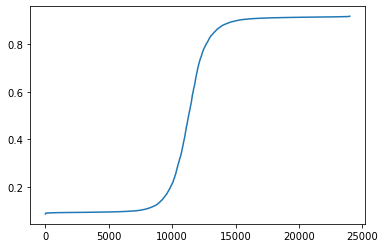

In [46]:
plt.plot(torch.sort(torch.cat(unbatched_preds)[:, 1])[0])

In [47]:
print(accuracy)

tensor(0.8588)


In [48]:
per_utt_acc = [(preds.argmax(dim=-1)==unbatched_labels[i]).sum().float()/float(unbatched_labels[i].size(0)) for i, preds in enumerate(unbatched_preds)]
auc = FM.auroc(torch.cat(unbatched_preds)[:,1], torch.cat(unbatched_labels))
fpr, tpr, thresh = FM.roc(torch.cat(unbatched_preds)[:,1], torch.cat(unbatched_labels))

In [49]:
per_utt_acc = np.array(per_utt_acc)

idxs = np.argsort(per_utt_acc)
per_utt_acc_sorted = per_utt_acc[idxs]
per_utt_lengths_sorted = np.array(unbatched_lengths)[idxs]
line_75 = int(len(per_utt_acc_sorted)*0.25)

In [50]:
per_utt_acc[idxs[3]]

0.3106796

In [140]:
# save some bad wavs
from scipy.io import wavfile

for i in range(4):
    utterance = unbatched_wavs[idxs[i]]
    wavfile.write(f'bad_ld_utt_{i}.wav', 16000, np.array(utterance))

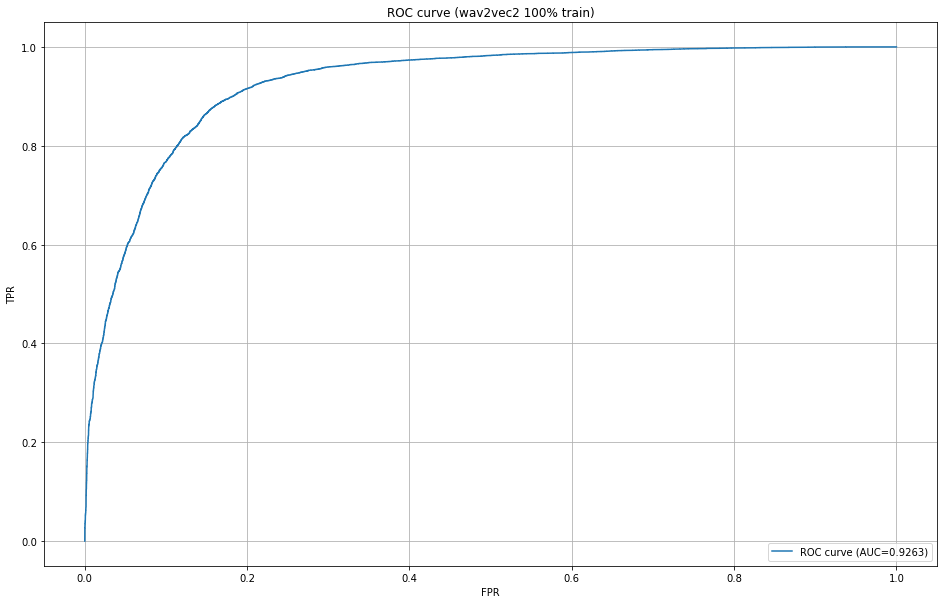

In [51]:
from matplotlib.pyplot import figure
figure(figsize=(16, 10))

plt.plot(fpr, tpr, label=f'ROC curve (AUC={auc:.4f})')

plt.legend(loc='lower right')
plt.title("ROC curve (wav2vec2 100% train)")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.grid()
#plt.savefig('../figs/roc_wav2vec2_base_100_trn.jpeg', dpi=500)

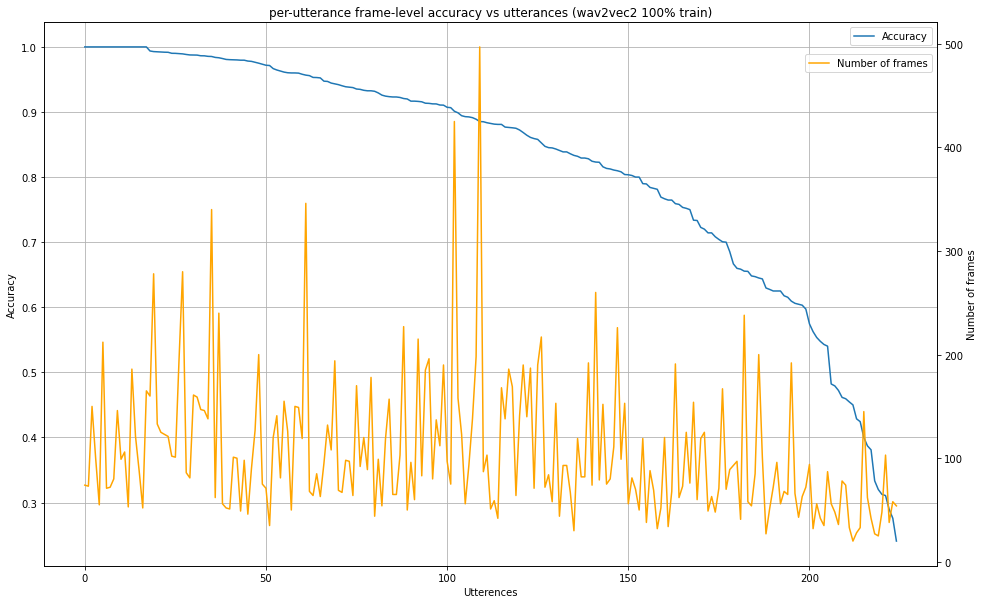

In [53]:
fig, ax1 = plt.subplots(figsize=(16,10))

ax1.plot(np.flip(per_utt_acc_sorted), label="Accuracy")

ax2 = ax1.twinx()
ax2.plot(np.flip(per_utt_lengths_sorted), label="Number of frames", color='orange')

ax1.legend()
ax2.legend(loc='best', bbox_to_anchor=(1,0.95))
ax2.set_ylabel("Number of frames")
ax1.set_title("per-utterance frame-level accuracy vs utterances (wav2vec2 100% train)")
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Utterences")
ax1.grid(True)
# plt.savefig('../figs/acc_v_utt_wav2vec2_base_100_trn.jpeg', dpi=500)

In [54]:
cm = np.array(FM.confusion_matrix(torch.cat(unbatched_preds).argmax(dim=-1), torch.cat(unbatched_labels), num_classes=2))

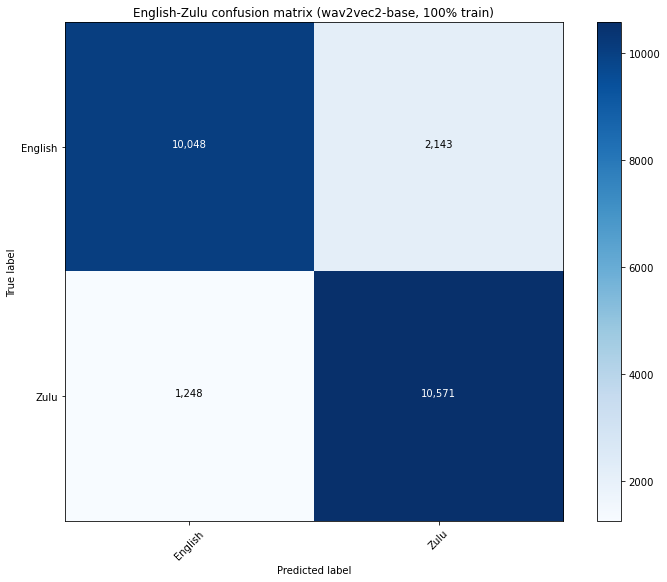

In [55]:
import itertools

plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('Blues')
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('English-Zulu confusion matrix (wav2vec2-base, 100% train)')
plt.colorbar()

target_names = ["English", "Zulu"]
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig("../figs/cm_wav2vec2_base_100_trn.jpeg", dpi=500)
plt.show()